In [2]:
%load_ext autoreload
import pickle as pkl
from matplotlib import pyplot as plt
import torch
import sys
import os
from typing import Literal
from tqdm import trange

## I. Load and Visualize real attention-label joint and conditional distributions ($p(a|y)$ and $p(y|a)$)

In [9]:
prev_path = os.path.realpath('..') 
if prev_path not in sys.path:
    sys.path.append(prev_path)

def pickle_load(file_name: str, method: Literal['torch', 'pickle'] = 'torch'):
    with open(file_name, 'rb') as f:
        return torch.load(f) if method == 'torch' else pkl.load(f)

proportion = '_0_05'
transpose=''
model_name = 'open_llama_13b'
model_name_2 = 'open_llama_13b_bak'
pos_features = pickle_load(f'../pretrained-models/kde/{model_name}/pos_attn_samples{proportion}{transpose}.pkl')
neg_features = pickle_load(f'../pretrained-models/kde/{model_name}/neg_attn_samples{proportion}{transpose}.pkl')
height_features = pickle_load(f'../pretrained-models/kde/{model_name}/height_attn_samples{proportion}{transpose}.pkl')
label_features = pickle_load(f'../pretrained-models/kde/{model_name}/label_attn_samples{proportion}{transpose}.pkl')
pos_features_2 = pickle_load(f'../pretrained-models/kde/{model_name_2}/pos_attn_samples{proportion}{transpose}.pkl')
neg_features_2 = pickle_load(f'../pretrained-models/kde/{model_name_2}/neg_attn_samples{proportion}{transpose}.pkl')
height_features_2 = pickle_load(f'../pretrained-models/kde/{model_name_2}/height_attn_samples{proportion}{transpose}.pkl')
label_features_2 = pickle_load(f'../pretrained-models/kde/{model_name_2}/label_attn_samples{proportion}{transpose}.pkl')

# pos_kde_estims = pickle_load(f'../pretrained-models/kde/{model_name}/pos_attn_conditional{proportion}{transpose}.pkl', method='pickle')
# neg_kde_estims = pickle_load(f'../pretrained-models/kde/{model_name}/neg_attn_conditional{proportion}{transpose}.pkl', method='pickle')
# conditional_probab_pos = pickle_load(f'../pretrained-models/kde/{model_name}/pos_arc_conditional{proportion}{transpose}.pkl', method='pickle')
# conditional_probab_neg = pickle_load(f'../pretrained-models/kde/{model_name}/neg_arc_conditional{proportion}{transpose}.pkl', method='pickle')
# x = pickle_load(f'../pretrained-models/kde/{model_name}/x{proportion}{transpose}.pkl', method='pickle')

# n_pos_samples, n_neg_samples = pos_features.shape[0], neg_features.shape[0]
# n_samples = n_pos_samples + n_neg_samples
# pos_probab, neg_probab = n_pos_samples / n_samples, n_neg_samples / n_samples

# max_attn_feature_val = max(pos_features.max().item(), neg_features.max().item())
# min_attn_feature_val = min(pos_features.min().item(), neg_features.min().item())

# x = torch.cat([torch.arange(round(min_attn_feature_val, 1) - 0.2, 0, 0.1), torch.arange(0, 1, 0.01), torch.arange(1, max_attn_feature_val + 0.2)]).to('cuda:0')

# for attn_feat_idx in trange(len(pos_kde_estims)): # attn_feat_idx (i)


In [10]:
print((pos_features == pos_features_2).all())
print((neg_features == neg_features_2).all())

tensor(True)
tensor(True)


In [3]:
# for i in trange(len(pos_kde_estims)):
#     fig = plt.figure()
#     plt.plot(x.cpu(), pos_kde_estims[i], label='pos')
#     plt.plot(x.cpu(), neg_kde_estims[i], label='neg')
#     plt.title(f'conditional pdf for head {i:03d}')
#     plt.legend()
#     plt.savefig(os.path.join('conditional_pdfs', f'{i:03d}.png'))
#     plt.close(fig)

In [4]:
# ! tar -zcf conditional_pdfs.tar conditional_pdfs/

In [5]:
# %autoreload 3

In [6]:
from explaination import integral_torch_cuda

In [ ]:

for pos_estim, neg_estim in zip(pos_kde_estims, neg_kde_estims):
    cdf_pos = integral_torch_cuda(x.to('cuda:0'), pos_estim.to('cuda:0'), definite=False)
    cdf_neg = integral_torch_cuda(x.to('cuda:0'), neg_estim.to('cuda:0'), definite=False)
    # print(cdf_pos[-1], cdf_neg[-1])
    fig = plt.figure()
    plt.plot(x.cpu(), cdf_pos.cpu())
    plt.show()
    plt.close(fig)
    break

## Generate synthetic data using known skewed distribution, comparing KDE and v-Information

In [8]:
from explaination import integral_torch_cuda, inference_by_func, estimate_mi, estimate_kde_torch
import scipy.stats as ss
from torch import nn, Tensor, tensor
from typing import List

KDE_DEVICE = 'cuda:0'

In [9]:
def generate_samples_from_distribution(x: Tensor, pdf: Tensor, n_samples: int):
    cdf = integral_torch_cuda(x, pdf, definite=False)
    cdf = cdf / cdf.max()
    random_samples = torch.rand(n_samples, device=x.device)
    indices = torch.searchsorted(cdf, random_samples, right=True)
    # indices = torch.clamp(indices, 1, len(xp)-1)
    # Get the x coordinates for interpolation
    x0 = x[indices - 1]
    x1 = x[indices]
    # Get the corresponding y coordinates for interpolation
    y0 = cdf[indices - 1]
    y1 = cdf[indices]
    # Perform linear interpolation
    slope = (x1 - x0) / (y1 - y0)
    result = x0 + slope * (random_samples - y0)
    return result


for pos_kde_estim, neg_kde_estim in zip(pos_kde_estims, neg_kde_estims):
    # generate synthetic data from the conditional distributions of positive and negative samples
    synthetic_data_pos = generate_samples_from_distribution(x.to(KDE_DEVICE), pos_kde_estims[0].to(KDE_DEVICE), len(pos_features))
    synthetic_data_neg = generate_samples_from_distribution(x.to(KDE_DEVICE), neg_kde_estims[0].to(KDE_DEVICE), len(neg_features))
    # train a network to distinguish between the synthetic data



In [10]:
estimated_kde_0 = estimate_kde_torch(x.to(KDE_DEVICE), synthetic_data.to(KDE_DEVICE))

0.08773163706064224 tensor(1.7187, device='cuda:0') tensor(0.5818, device='cuda:0')


tensor(1.) tensor(1.)


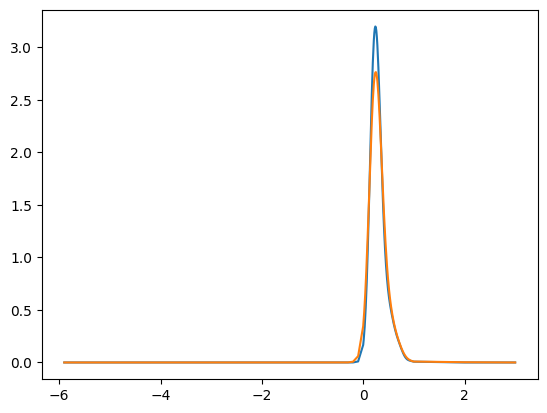

In [11]:
fig = plt.figure()
plt.plot(x.cpu(), pos_kde_estims[0].cpu())
plt.plot(x.cpu(), estimated_kde_0.cpu())